# testing

this implements some basic visualisations based off of the specifications document [found here](https://unimelbcloud-my.sharepoint.com/:w:/r/personal/cie-team_unimelb_edu_au/_layouts/15/Doc.aspx?sourcedoc=%7BF25CABAF-5F34-422E-BB9A-DDC20BEB552B%7D&file=Frost%20Warning%20tool%20specifications_V5_NoRisk.docx&action=default&mobileredirect=true)


In [37]:
import os
import yaml
import json
import pprint
import shapely

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import eratos.climate as eratosClimate
import eratos.helpers as helpers
import geopandas as gpd

from eratos.creds import AccessTokenCreds
from eratos.adapter import Adapter
from yaml.loader import SafeLoader
from keplergl import KeplerGl
from shapely.geometry import box
from shapely import wkt
from shapely import wkt, geometry
from tabulate import tabulate
from datetime import  timezone
from datetime import date

ERATOS_KEY = os.environ['ERATOS_KEY']
ERATOS_SECRET = os.environ['ERATOS_SECRET']

ecreds = AccessTokenCreds(
  ERATOS_KEY,
  ERATOS_SECRET
)
eadapter = Adapter(ecreds)

In [3]:
def get_forecast_data_for_points(ern: str, point_list: list[str]):

    # Parse the date range using the iso8601 format
    e_data = eadapter.Resource(ern=ern)
    #access the gridded data via the gridded data adapter:
    gridded_e_data = e_data.data().gapi()
         # Load Point strings as Shapely Points
    wkt_list = []
    for point in (point_list):
        loc_shape = wkt.loads(point)
        if type(loc_shape) is not geometry.Point:
            raise ValueError('value inside point_list should be a WKT point')
        loc= [loc_shape.y, loc_shape.x]
        wkt_list.append(loc)


    data_query_array = gridded_e_data.get_point_slices(gridded_e_data.get_key_variables()[0], 'SPP', pts=wkt_list, starts=[0], ends=[-1],strides =  [1])

    times = []
    for unix_time in gridded_e_data.get_subset_as_array('time'):

        date = datetime.datetime.fromtimestamp(unix_time)

        # Format the datetime object as an ISO 8601 string
        date_8601 = date.isoformat()
        times.append(date_8601)

    return data_query_array,times

def get_forecast_multiple_data_at_point(ern_list:list[str], point:str):
     data = {}
     times = None
     for ern in ern_list:
         e_data = eadapter.Resource(ern=ern)
         gridded_e_data = e_data.data().gapi()
         if times is None:
             times = gridded_e_data.get_subset_as_array('time')
             data['times'] = times
         variable = gridded_e_data.get_key_variables()[0]

         p = wkt.loads(point)
         pt = [p.y, p.x]
         data[variable] = gridded_e_data.get_point_slices(
           variable, 'SPP', pts = [pt], starts = [0], ends=[-1], strides=  [1]
         )
     return data
     data = pd.DataFrame(data)
     data.times = pd.to_datetime(data.times)
     return data


In [4]:
ern_list = [
    'ern:e-pn.io:resource:eratos.blocks.bom.adfd.3hourlyskycoverforecastau6km',
    'ern:e-pn.io:resource:eratos.blocks.bom.adfd.dailymintempforecastau6km',
    'ern:e-pn.io:resource:eratos.blocks.bom.adfd.dewpointtempforecastau6km'
]
location = 'POINT(141.181121 -34.147659)'


# data generation

given that we don't have actual data for some of the stuff we want to do yet i'll just generate some synthetic data

In [49]:
# use silo data set and forecast
min_temp_hist_ern = "ern:e-pn.io:resource:eratos.blocks.silo.mintemperature"
min_temp_forecast_ern = "ern:e-pn.io:resource:eratos.blocks.bom.adfd.dailymintempforecastau6km"
silo_min = eadapter.Resource(ern ="ern:e-pn.io:resource:eratos.blocks.silo.mintemperature")
gridded_min = silo_min.data().gapi()

In [17]:
?np.arange

In [18]:
np.linspace(2,4,7)

array([2.        , 2.33333333, 2.66666667, 3.        , 3.33333333,
       3.66666667, 4.        ])

In [18]:
# let's just say we set a start date and end date like this
startDate = '2022-01-01'
endDate = '2022-12-19'
date_range = pd.date_range(startDate, endDate, freq='D')
# get the data, this is historical
data = gridded_min.get_timeseries_at_points(var = gridded_min.get_key_variables()[0],
                                     point_list = [location],
                                     startDate=startDate,
                                     endDate=endDate).flatten()
data_dic = {
    'actual':data,
}
# create some fake 'predictions', these will be considered as the 7 day forecasts
for i, var in zip(range(7), np.linspace(1,4,7)):
    # this is probably unrealistic but let's roll with it
    data_dic[f'prediction_day{i+1}'] = data + sp.stats.norm(0,np.sqrt(var)).rvs(data.shape[0])

df = pd.DataFrame(data_dic)
df.index = date_range
df.to_csv('./data/fake_data.csv')

In [28]:
# this is also likely not realistic but a simple g
def get_likelihood(threshold, data, sd):
    """
    calculate likelihood just based on an assumed normal distribution
    take the data as the mean and just assume some variance
    essentially for each data point we calculate P(X < threshold)
    where X ~ N(predicted temp, assumed standard deviation)
    """
    return sp.stats.norm(data, sd).cdf(threshold)

## This week in review

Shows the predicted temperatures and compares them to observed values. Show the predicted values as they were 2 days before the respective day.

Shows the predicted likelihood of a critical event each day.

plots are to be made pretty and stuff later

In [52]:
data = pd.read_csv('./data/fake_data.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
startDate = '2022-12-12'
endDate = '2022-12-19'

# endDate = (datetime.datetime.now() - datetime.timedelta(days = 1)).date().strftime(format='%Y-%m-%d')
# # get date one week ago
# startDate = (datetime.datetime.now() - datetime.timedelta(days = 7)).date().strftime(format='%Y-%m-%d')

date_range = pd.date_range(startDate, endDate, freq='D')
week_data = data.loc[date_range]

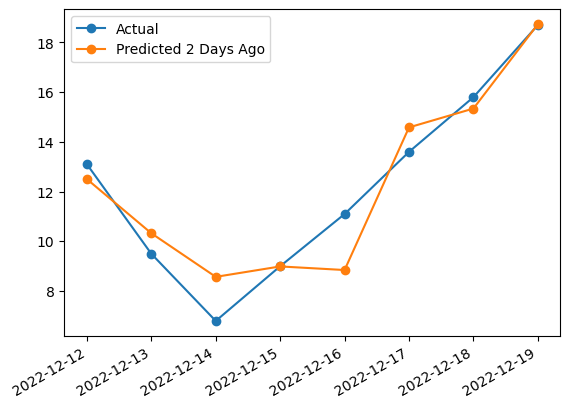

In [53]:
fig, ax = plt.subplots()
ax.plot(week_data.actual, marker = 'o', label = 'Actual')
ax.plot(week_data['prediction_day2'], marker = 'o', label = 'Predicted 2 Days Ago')
ax.legend()
fig.autofmt_xdate()

In [63]:
# forecasted likelihood vs actual occurrence of frost? just put as table
threshold = 12
likelihoods = get_likelihood(
    threshold= threshold,
    data = week_data.prediction_day2,
    sd = np.sqrt(2)
)
pd.DataFrame({
    'likelihoods':likelihoods,
    'frost_yes' : week_data.actual < threshold,
}).T

,2022-12-12,2022-12-13,2022-12-14,2022-12-15,2022-12-16,2022-12-17,2022-12-18,2022-12-19
likelihoods,0.360958,0.881781,0.992307,0.98329,0.987092,0.033835,0.009049,0.000001
frost_yes,False,True,True,True,True,False,False,False


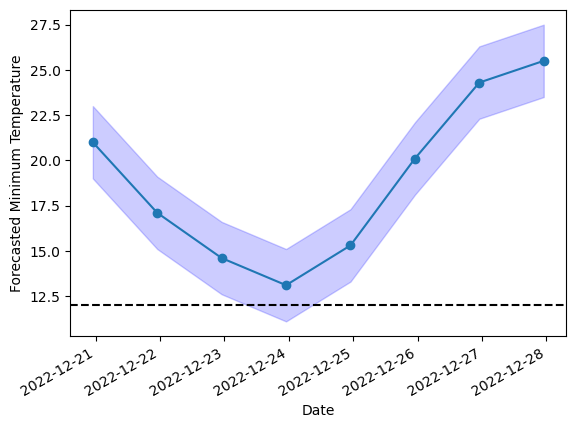

In [68]:
# forecasted temperatures for next week
forecast, times = get_forecast_data_for_points(min_temp_forecast_ern, point_list=[location])
# could also essentially append the data daily
times = pd.to_datetime(times)

# another line plot
fig, ax = plt.subplots()
ax.plot(times, forecast[0], marker = 'o')
# get some error bars too
ax.fill_between(times, forecast[0] - 2, forecast[0] + 2, color='blue', alpha=0.2, label = '1std')
ax.axhline(threshold, color = 'black', linestyle = 'dashed')
ax.set_xlabel('Date')
ax.set_ylabel('Forecasted Minimum Temperature')
fig.autofmt_xdate()

In [69]:
# get likelihoods of frost each day in a table
pass

# 5 to 1 day warning

In [ ]:
# dew point
